# Simple processes


**Code:** #122-000

**File:** `apps/ideal_gas/simple_processes.ipynb`

**Run it online:** [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Ikergym/MinervaLab/master?filepath=apps%2Fideal_gas%2Fsimple_processes.ipynb)

-----------

The aim of this notebook is to help visualize the most common processes in a $PV$ diagram.

## Interface

The main interface (``main_block_122_000``) is divided in three VBox: ``left_block_122_000``, ``center_block_122_000`` and ``right_block_122_000``.

``left_block_122_000`` contains the following widgets to control the figure: ``gamma_dropdown``, ``mol_slider``, ``vi_slider``, ``pi_slider``, ``Ti_text`` and ``process_dropdown``.

``center_block_122_000`` contains the bqplot figure ``fig_122_001``, the input widget ``vf_slider`` and two output widgets: ``pf_text`` and ``Tf_text``.

``right_block_122_000`` contains the widgets related to energy: ``work_text``, ``energy_text``, ``heat_text`` and ``show_work_check``.

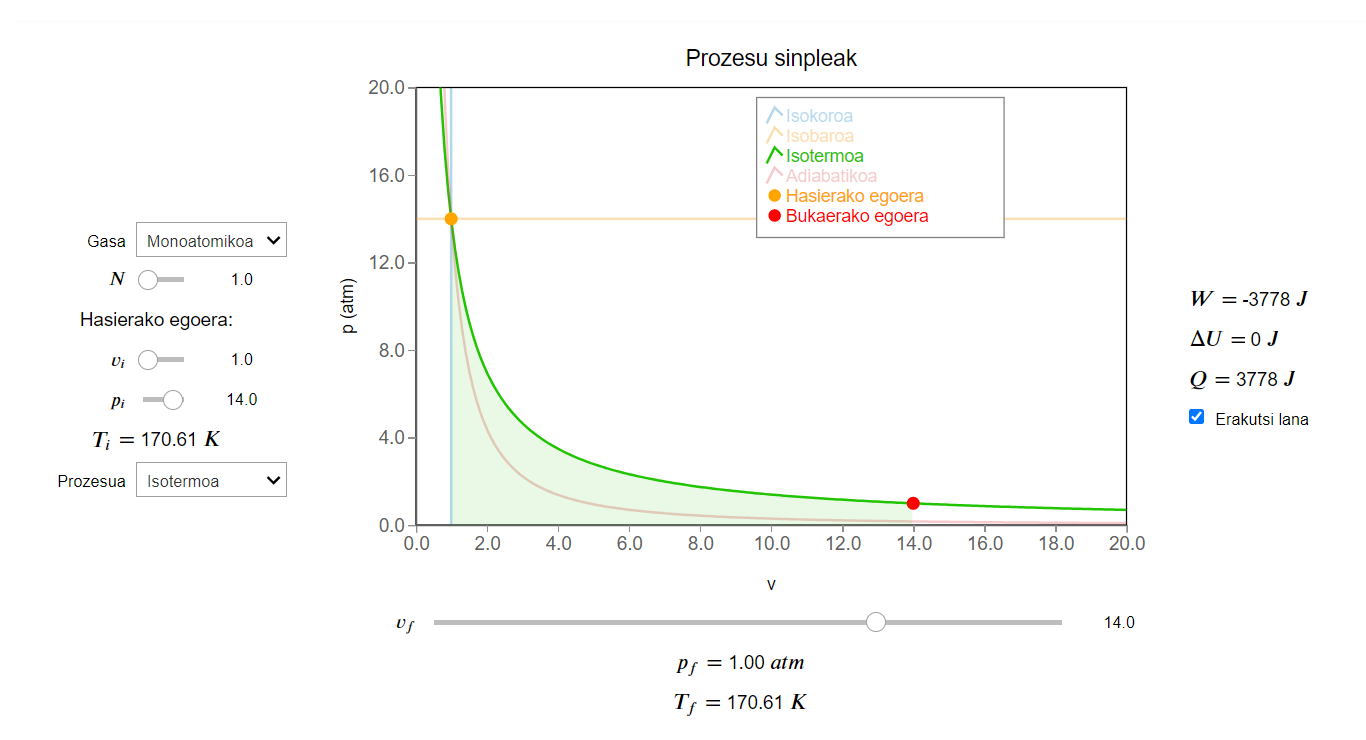

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [1]:
from IPython.display import Image
Image(filename='../../static/images/apps/ideal_gas/122-000.png')

## CSS

A custom `css` file is used to improve the interface of this application. It can be found [here](https://github.com/jongablop/MinervaLab/blob/master/static/custom.css).

In [ ]:
from IPython.display import HTML
display(HTML("<head><link rel='stylesheet' type='text/css' href='./../../static/custom.css'></head>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

## Packages

In [ ]:
import numpy as np

import bqplot as bq
import bqplot.marks as bqm
import bqplot.scales as bqs
import bqplot.axes as bqa

import ipywidgets as widgets

## Physical functions

This are the functions that have a physical meaning:

- `get_isochore`
- `get_isobar`
- `get_isotherm`
- `get_isenthropic`
- `get_pf`
- `get_work`
- `get_energy_change`
- `change_mol`


In [ ]:
def get_isochore(vi,pi):
    '''
    This function calculates the (x,y) points to
    draw an isochoric curve for an ideal gas.
    
    Inputs:
    vi: float value for initial point volume
    pi: float value for initial point pressure
    
    Returns:
    v_values: 1d numpy array of len=pts containing the x values of the points
    p_values: 1d numpy array of len=pts containing the y values of the points
    '''
    
    v_values = np.full((pts), vi)
    p_values = np.linspace(p_min,p_max,pts)
    return v_values, p_values

In [ ]:
def get_isobar(vi, pi):
    '''
    This function calculates the (x,y) points to
    draw an isobaric curve for an ideal gas.
    
    Inputs:
    vi: float value for initial point volume
    pi: float value for initial point pressure
    
    Returns:
    v_values: 1d numpy array of len=pts containing the x values of the points
    p_values: 1d numpy array of len=pts containing the y values of the points
    '''
    
    v_values = np.linspace(v_min, v_max, pts)
    p_values = np.full((pts), pi)
    return v_values, p_values

In [ ]:
def get_isotherm(vi, pi):
    '''
    This function calculates the (x,y) points to
    draw an isothermal curve for an ideal gas.
    
    Inputs:
    vi: float value for initial point volume
    pi: float value for initial point pressure
    
    Returns:
    v_values: 1d numpy array of len=pts containing the x values of the points
    p_values: 1d numpy array of len=pts containing the y values of the points
    '''
    
    v_values = np.linspace(v_min, v_max, pts)
    p_values = np.empty((pts))
    for i in range(pts):
        p_values[i] = pi* vi/v_values[i]
    return v_values, p_values

In [ ]:
def get_isenthropic(vi, pi, gamma):
    '''
    This function calculates the (x,y) points to
    draw an isenthropic curve, for an ideall gas with adiabatic coefficient gamma.
    
    Inputs:
    vi: float value for initial point volume
    pi: float value for initial point pressure
    gamma: adiabatic coefficient of the gas
    
    Returns:
    v_values: 1d numpy array of len=pts containing the x values of the points
    p_values: 1d numpy array of len=pts containing the y values of the points
    '''
    
    v_values = np.linspace(v_min, v_max, pts)
    p_values = np.empty((pts))
    for i in range(pts):
        p_values[i] = pi* (vi/v_values[i])**gamma
    return v_values, p_values

In [ ]:
def get_pf(vi, pi, vf, gamma, process):
    '''
    This function calculates the final pressure pf for a given process
    starting at point (vi,pi) for a gas with adiabatic coefficient gamma
    
    Inputs:
    vi: float value for initial point volume
    pi: float value for initial point pressure
    vf: float value for final point volume
    gamma: adiabatic coefficient of the gas
    process: integer index to characterize each process
    
    Returns:
    x_values: 2d numpy array of dimension (4,pts) with the x_values for each process
    x_values: 2d numpy array of dimension (4,pts) with the y_values for each process
    '''
    
    if process == 0:
        pf = pf_slider.value
    elif process == 1:
        pf = pi
    elif process == 2:
        pf = pi* vi/vf
    elif process == 3:
        pf = pi* (vi/vf)**gamma
    return pf

In [ ]:
def get_work(vi, pi, vf, pf, v_values, p_values):
    '''
    This function calculates the work done on the system (positive work)
    or done by the system (negative work), in a process described by the set of points
    (v_value, p_values), that goes from (vi,pi) to (vf,pf). This is accomplished by numerically
    integrating the curve:
    
    $$W = -\int_{i}^{f} pdV $$
    
    Inputs:
    vi: float value for initial point volume
    pi: float value for initial point pressure
    vf: float value for final point volume
    pf: float value for final point pressure
    v_values: 1d numpy array of len=pts containing the x values of the points
    p_values: 1d numpy array of len=pts containing the y values of the points
    
    
    Returns:
    W = float value for the work done on the system (positive W) or by the system (negative W)
    '''

    W = 0.0
    dv = (v_max - v_min) / pts
    j = 0
    if vf < vi:
        vi, vf = vf, vi
        dv = -dv
    for i  in range(pts):
        v = v_values[i]
        p = p_values[i]
        if v > vf:
            break
        elif v > vi:
            W = W - p*dv
    W = C*W
    return W
        

In [ ]:
def get_energy_change(vi, pi, vf, pf, gamma):
    '''
    This function calculates the change in the energy of an ideal gas
    with adiabatic coefficien gamma tha undergoes a process starting
    on point (vi,pi) and ending on point (vf,pf)
    
    Inputs:
    vi: float value for initial point volume
    pi: float value for initial point pressure
    vf: float value for final point volume
    pf: float value for final point pressure
    gamma: adiabatic coefficient of the gas
    
    '''

    Cv = 1.0 / (gamma-1.0) #Adimensional value of Cv (Cv/NR indeed)
    dU = C * Cv*(vf*pf - vi*pi) # Energy difference in Joules
    return dU

In [ ]:
def change_mol(change):
    '''
    This function calculates the new temperature values whenever
    the mol value is changed, and calls the update_pT_label function
    to update is outputed values. 
    '''

    vi = vi_slider.value
    pi = pi_slider.value
    vf = vf_slider.value
    gamma = gamma_dropdown.value
    process = process_dropdown.value
    N = mol_slider.value
    
    Ti = vi*pi/N/R
    pf = get_pf(vi, pi, vf, gamma, process)
    Tf = vf*pf/N/R
    
    update_pT_labels(Ti,pf,Tf)

## Functions related with the interaction

In [ ]:
def get_marks(vi, pi, gamma):
    '''
    This function builds a 2d numpy array containing the sets of
    (x,y) points for each process.
    
    Inputs:
    vi: float value for initial point volume
    pi: float value for initial point pressure
    gamma: adiabatic coefficient of the gas
    
    Returns:
    x_values: 2d numpy array of dimension (4,pts) with the x_values for each process
    x_values: 2d numpy array of dimension (4,pts) with the y_values for each process
    '''
    
    x_values = []
    y_values = []
    
    isochore = get_isochore(vi, pi)
    x_values.append(isochore[0])
    y_values.append(isochore[1])
    
    isobar = get_isobar(vi, pi)
    x_values.append(isobar[0])
    y_values.append(isobar[1])
    
    isotherm = get_isotherm(vi, pi)
    x_values.append(isotherm[0])
    y_values.append(isotherm[1])
    
    isenthropic = get_isenthropic(vi, pi, gamma)
    x_values.append(isenthropic[0])
    y_values.append(isenthropic[1])
    
    return x_values, y_values

In [ ]:
def update_pT_labels(Ti,pf,Tf):
    '''
    This function updates the labels of the pressure and
    Temperatures widgets that show as outputs on the GUI.
    This function is called whenever any of this values is changed.
    
    Inputs:
    Ti: float value for new initial temperature
    pf: float value for new final pressure
    Tf: float value for new final temperature
    '''
    
    Ti_text.value = '%.2f' % Ti
    pf_text.value ='%.2f' % pf
    Tf_text.value ='%.2f' % Tf

In [ ]:
def update_energy_labels(W, dU, Q):
    '''
    This function updates the labels of the energies
    widgets that show as outputs on the GUI.
    his function is called whenever any of this values is changed.
    
    Inputs:
    W: float value for new work
    dU: float value for new energy change
    Q: float value for new heat
    '''
    
    work_text.value = '%.0f' % W
    energy_text.value ='%.0f' % dU
    heat_text.value ='%.0f' % Q

In [ ]:
def update_fill(change):
    '''
    This function controls the filled area mark that represents
    the work done. Updates the values for defining the are whenever
    the curve changes. It also controls when to show or hide the area
    and it's color (to match the color of the current process).
    '''
    
    vi = vi_slider.value
    vf = vf_slider.value
    process = process_dropdown.value
    
    v_values = isocurves.x[process]
    p_values = isocurves.y[process]
    
    fill_x = []
    fill_y = []
    
    if show_work_check.value == True:
        
    
        for i in range(pts):
            v = v_values[i]
            p = p_values[i]
            if v > vi and v < vf:
                fill_x.append(v)
                fill_y.append(p)
        fillcurve.x = fill_x
        fillcurve.y = fill_y
        fillcurve.fill_opacities = [0.1]
        
    else:
        fillcurve.opacities = [0.0]
    
    fillcurve.x = fill_x
    fillcurve.y = fill_y
    newcolor = colors[process]
    fillcurve.fill_colors = [colors[process]]

In [ ]:
def update_points(change):
    '''
    This function updates the markers of the initial and final points
    and recalculates the values for temperature and energies and its
    outputed values.
    '''
    
    vi = vi_slider.value
    pi = pi_slider.value
    gamma = gamma_dropdown.value
    process = process_dropdown.value
    N = mol_slider.value
    
    # If process is isochoric, vf must be updated to equal vi
    if process == 0:
        vf_slider.value=vi
    vf = vf_slider.value

    #Calculate temperature and pressure values
    Ti = vi*pi/N/R
    pf = get_pf(vi, pi, vf, gamma, process)
    Tf = vf*pf/N/R
    
    #Calculate energies
    v_values = isocurves.x[process]
    p_values = isocurves.y[process]
    W=get_work(vi,pi,vf,pf,v_values,p_values)
    dU=get_energy_change(vi,pi,vf,pf,gamma)
    Q=dU-W
    
    # Update the marks
    InitialPoint.x = [vi]
    InitialPoint.y = [pi]
    FinalPoint.x = [vf]
    FinalPoint.y = [pf]
    
    update_pT_labels(Ti,pf,Tf)
    update_energy_labels(W,dU,Q)
    
    update_fill(None)

In [ ]:
def change_process(change):
    '''
    This functions updated the opacities of the curves, when the
    selected proces is changed. It then calls the update_points function
    to update the inital and final point, as the final point pressure will
    in general change when the process changes. If a isochoric process is
    selected, it changes the righ_block_122_000 layout to disable final
    volume slider and enable a new slider for final pressure. If any other
    process is selected, the default layout is displayed.
    '''
        
    vi = vi_slider.value
    process = process_dropdown.value
    
    # Update opacities
    op = [0.3,0.3,0.3,0.3]
    op[process] = 1.0
    isocurves.opacities = op
    
    # If process is isochoric, vf is fixed, so vf_slider must be disabled
    if process == 0:
        vf_slider.value = vi
        vf_slider.disabled = True
        center_block_122_000.children = [fig_122_001,vf_slider,
                                         pf_slider,
                                         widgets.HBox([widgets.Label(value='$T_f=$'),Tf_text,widgets.Label(value='$K$')])
                                        ]
    else:
        vf_slider.disabled = False
        center_block_122_000.children = [fig_122_001,vf_slider,
                                         widgets.HBox([widgets.Label(value='$p_f=$'),pf_text,widgets.Label(value='$atm$')]),
                                         widgets.HBox([widgets.Label(value='$T_f=$'),Tf_text,widgets.Label(value='$K$')])
                                        ]
    
    # Update final point tracer
    update_points(None)

In [ ]:
def update_figure(change):
    '''
    This funcion recalculates the (x,y) poit sets of the four processes
    whenever the inital point is changed and replots them. Then it calls
    the update_point function to update the intial and final point marks
    and recalculate all the other parameters
    '''
    
    vi = vi_slider.value
    pi = pi_slider.value
    gamma = gamma_dropdown.value
    
    # Update the isocurves
    x_values, y_values = get_marks(vi, pi, gamma)
    isocurves.x = x_values
    isocurves.y = y_values
    
    update_points(None)

## Main interface

In [ ]:
#######################
###   PARAMETERS    ###
#######################

# Global Parameters
R = 0.082057 # In atm*L/mol/K
C = 101.325 # Conversion factor from atm*L to J -> C = J/atmL

pts = 200 # Number of points for plotting each process

# Limits of parameters (volumes in L, pressures in atm)
v_min = 0.01
v_max = 20.0
p_min = 0.01
p_max = 20.0

# Default values
vi = 1.0
pi = 14.0
vf = 14.0
gamma = 5.0/3.0 # Adiabatic index (5/3 for monoatomic gases, 7/5 for diatomic gases at room temperature)
process = 2 # Index for each process: {0: 'isochoric', 1: 'isobaric', 2: 'isothermal', 3: 'isenthropic' or 'adiabatic'}
N = 1.0 # Number of mols of gas

# Default final state
vf = 14.0

# Figure parameters
colors = ['#0079c4','#f09205','#21c400','#dd4e4f']
isocurves_opacities = [0.3,0.3,1.0,0.3]


#######################
###INIT CALCULATIONS###
#######################

# Pressure and Tempetures
Ti = vi*pi/N/R
pf = get_pf(vi, pi, vf, gamma, process)
Tf = vf*pf/N/R

# Isocurves
(x_values, y_values) = get_marks(vi, pi, gamma)

# Energies
W = get_work(vi, pi, vf, pf, x_values[process], y_values[process])
dU = get_energy_change(vi, vf, pi, pf, gamma)
Q = dU - W


########################
###CREATE THE FIGURES###
########################

fig_122_001 = bq.Figure(title='Prozesu sinpleak',
                marks=[],
                axes=[],
                padding_x = 0.0,
                padding_y = 0.0,
                animation_duration=0,
                legend_location='top-right',
                legend_style= {'fill': 'white', 'stroke': 'grey'},
                background_style= {'fill': 'white',  'stroke': 'black'},
                fig_margin=dict(top=70, bottom=60, left=80, right=30),
                toolbar = True,
                layout=widgets.Layout(width='95%')
    )


scale_x = bqs.LinearScale(min = v_min, max = v_max, allow_padding = False)
scale_y = bqs.LinearScale(min = p_min, max = p_max, allow_padding = False)

axis_x = bqa.Axis(scale=scale_x,
                tick_format='.1f',#'0.2f',
                tick_style={'font-size': '15px'},
                tick_values = np.linspace(v_min, v_max, 11),
                grid_lines = 'none',
                grid_color = '#8e8e8e', 
                label='v',
                label_location='middle',
                label_style={'stroke': 'black', 'default-size': 35},
                label_offset='50px')

axis_y = bqa.Axis(
                scale=scale_y,
                tick_format='.1f',#'0.2f',
                tick_style={'font-size': '15px'},
                tick_values= np.linspace(p_min, p_max, 6),
                grid_lines = 'none',
                grid_color = '#8e8e8e', 
                orientation='vertical',
                label='p (atm)',
                label_location='middle',
                label_style={'stroke': 'red', 'default_size': 35},
                label_offset='50px')

fig_122_001.axes = [axis_x,axis_y]


########################
####CREATE THE MARKS####
########################


isocurves = bqm.Lines(
                x = x_values, 
                y = y_values, 
                scales = {'x': scale_x, 'y': scale_y},
                colors = colors,
                opacities = isocurves_opacities,
                #fill_colors = ['green'],
                #fill_opacities = [0.0],
                #fill = 'bottom',
                labels = ['Isokoroa', 'Isobaroa', 'Isotermoa', 'Adiabatikoa'],
                display_legend=True
)




InitialPoint = bqm.Scatter(
    name = 'Initial Point',
    x = [vi],
    y = [pi],
    scales = {'x': scale_x, 'y': scale_y}, 
    #opacities = [1.0],
    visible = True,
    colors = ['orange'],
    names = [],
    labels=['Hasierako egoera'],
    display_legend = True
)      


FinalPoint = bqm.Scatter(
    name = 'Final Point',
    x = [vf],
    y = [pf],
    scales = {'x': scale_x, 'y': scale_y}, 
    #opacities = [1.0],
    visible = True,
    colors = ['red'],
    names = [],
    labels=['Bukaerako egoera'],
    display_legend = True
)      

fillcurve = bqm.Lines(
                x = [], 
                y = [], 
                scales = {'x': scale_x, 'y': scale_y},
                colors = colors,
                opacities = [0.0],
                fill_colors = [colors[process]],
                fill_opacities = [0.0],
                fill = 'bottom',
                labels = ['Lana'],
                display_legend=False
)

fig_122_001.marks = [isocurves, InitialPoint, FinalPoint, fillcurve]

########################
######  WIDGETS  #######
########################


## Left block (Initial state and process block)

gamma_dropdown = widgets.Dropdown(
    options=[('Monoatomikoa',5.0/3.0), ('Diatomikoa',7.0/5.0)],
    value=gamma,
    description='Gasa',
    disabled=False,
    layout=widgets.Layout(width='95%')
)

gamma_dropdown.observe(update_figure, 'value')

mol_slider = widgets.FloatSlider(
    value=1.0,
    min=v_min,
    max=v_max,
    step=0.1,
    description='$N$',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    layout=widgets.Layout(width='95%'),
)

mol_slider.observe(change_mol, 'value')



vi_slider = widgets.FloatSlider(
    value=vi,
    min=v_min,
    max=v_max,
    step=0.1,
    description='$v_i$',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    layout=widgets.Layout(width='95%'),
)

vi_slider.observe(update_figure, 'value')


pi_slider = widgets.FloatSlider(
    value=pi,
    min=p_min,
    max=p_max,
    step=0.1,
    description='$p_i$',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    layout=widgets.Layout(width='95%')
)

pi_slider.observe(update_figure, 'value')

Ti_text = widgets.Label(value='%.2f' % Ti)


process_dropdown = widgets.Dropdown(
    options=[('Isokoroa',0),('Isobaroa',1), ('Isotermoa',2), ('Adiabatikoa',3)],
    value=2,
    description='Prozesua',
    disabled=False,
    layout=widgets.Layout(width='95%')
)

process_dropdown.observe(change_process, 'value')


## Center block (figure block)

vf_slider = widgets.FloatSlider(
    value=vf,
    min=v_min,
    max=v_max,
    step=0.1,
    description='$v_f$',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    layout=widgets.Layout(width='95%'),
)

vf_slider.observe(update_points, 'value')

pf_text = widgets.Label(value='%.2f' % pf)
Tf_text = widgets.Label(value='%.2f' % Tf)

pf_slider = widgets.FloatSlider(
    value=pf,
    min=p_min,
    max=p_max,
    step=0.1,
    description='$p_f$',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    layout=widgets.Layout(width='95%'),
)

pf_slider.observe(update_points, 'value')


## Right block (energy block)

work_text = widgets.Label(value='%.0f' % W)
energy_text = widgets.Label(value='%.0f' % dU)
heat_text = widgets.Label(value='%.0f' % Q)

show_work_check = widgets.Checkbox(
    description='Erakutsi lana',
    disabled=False,
    value=False,
    layout=widgets.Layout(width='95%'),
    indent=False
)

show_work_check.observe(update_fill,'value')


########################
######  LAYOUT  ########
########################


## Left Block ##
left_block_122_000 = widgets.VBox([], layout=widgets.Layout(width='20%', align_items='center'))
left_block_122_000.children = [gamma_dropdown, mol_slider, widgets.Label(value="Hasierako egoera:"), vi_slider, pi_slider,
                               widgets.HBox([widgets.Label(value='$T_i=$'),Ti_text,widgets.Label(value='$K$')]),
                               process_dropdown]
                              
## Center Block ##
center_block_122_000 = widgets.VBox([fig_122_001], layout=widgets.Layout(width='65%', align_items='center'))
center_block_122_000.children = [fig_122_001,vf_slider,
                                 widgets.HBox([widgets.Label(value='$p_f=$'),pf_text,widgets.Label(value='$atm$')]),
                                 widgets.HBox([widgets.Label(value='$T_f=$'),Tf_text,widgets.Label(value='$K$')])
                                ]

## Right Block ##
right_block_122_000 = widgets.VBox([], layout=widgets.Layout(width='15%', align_items='flex-start'))
right_block_122_000.children = [
                                widgets.HBox([widgets.Label(value='$W=$'),work_text,widgets.Label(value='$J$')]),
                                widgets.HBox([widgets.Label(value='$\Delta U=$'),energy_text,widgets.Label(value='$J$')]),
                                widgets.HBox([widgets.Label(value='$Q=$'),heat_text,widgets.Label(value='$J$')]),
                                show_work_check
                               ]
                               
                                

## Main Block ##

main_block_122_000 = widgets.HBox([],layout=widgets.Layout(width='100%', align_items='center'))
main_block_122_000.children = [left_block_122_000, center_block_122_000,right_block_122_000]

main_block_122_000